In [4]:
import csv
import pandas as pd
import numpy as np
from patsy import dmatrices
from pulp import *
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_poisson_deviance
from sklearn.model_selection import cross_val_score

import seaborn as sns
from sklearn.cluster import KMeans

import statsmodels.api as sm

calcio_A = pd.read_pickle("calcio_A.pk1")
calcio_C = pd.read_pickle("calcio_C.pk1")
calcio_D = pd.read_pickle("calcio_D.pk1")
calcio = pd.read_pickle("calcio.pk1")

# Part 2: K-Means Clustering

Instead of looking at individual players where there can be large errors in predicted value, as seen in part 1, we will classify the players from each groups (A, C, D) into clusters by implementing k-means clustering

The below code is used to iterrate over the possible amount of clusters, and we add the WCSS value for each into a series so we can analyze it with a graph. WCSS is the sum of squared distance between each point and the centroid in a cluster. We use matplotlib to plot the WCSS vs size of cluster, and we will use the "Elbow Method" to find the appropriate amount.


In [5]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(np.array(calcio_A["20/21_Value"]).reshape(-1,1))
    wcss.append(kmeans.inertia_)

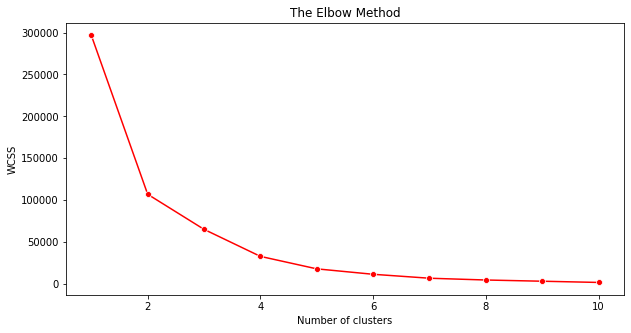

In [6]:
plt.figure(figsize=(10,5))
sns.lineplot(range(1, 11), wcss,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#KMEANS: Calcio_A = 3, C = 3, D = 3


Above we see the plotted graph. The Elbow Method requires us to see at what point the drop off in WCSS becomes less drastic. We want to minimize WCSS so that the points are closer to the centroids, but at the same time we don't want to overfit and create too many clusters. We can see the elbow point is at 3 clusters. There is an argument for 4 too as the line still has some noticable gradient between 3 and 4, but for simplicity sake we will take our amount of clusters as 3. 

These we can then classify as Low, Medium and High. In this demonstration the data was run for the attackers only, but I ran the test of the Defenders and Midfielders too with similar results. We will classify the players in each group into 3 clusters.

Now we can perform the clustering over each group. We put the cluster value for each player into a new column "cluster". However, the numbers here will change every time the code is run. One run the highest tier could be cluster 2, and the next time cluster 3. Because of this, we create another column "Tier" and for now label every player "Mid".

In [7]:
players = [calcio_A, calcio_C, calcio_D] 

for i in players:

    kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
    y_kmeans = kmeans.fit_predict(np.array(i["21/22_Value"]).reshape(-1,1))
    
    
    i["cluster"] = y_kmeans.tolist()
    
    i["Tier"] = "Mid"   
    

Another compensation is added here due to a defense modifier in the game. If you start with 4 defenders, you get +1 point every time they average a rating of 6 between them, and +3 if they average a rating of 6.5. The potential to contribute to these additional points earns each defender a boost of 0.16 points per game, which we add on in order to capture this.

In [8]:
calcio["2 YR AVG"].loc[calcio["R"] == "D"] += 0.16

C:\Users\Stevan\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Below, we assign each cluster to the Low, Mid or High categories. We take the mean of each "Tier" and use if statements to determine if they are lower or higher than the other means, and use these statements to determine which Tier is which.

We create a new dataframe called calcio again and append the split dataframes into it, to get all our data back in once place.

In [9]:
calcio = pd.DataFrame()

for i in [calcio_A, calcio_C, calcio_D]:

    Tier0 = i.loc[i["cluster"] == 0]
    Tier1 = i.loc[i["cluster"] == 1] 
    Tier2 = i.loc[i["cluster"] == 2]

    mean0 = (Tier0["21/22_Value"].mean())
    mean1 = (Tier1["21/22_Value"].mean())
    mean2 = (Tier2["21/22_Value"].mean())
    
    #TierHigh
    if mean0 > mean1 and mean0 > mean2:
        
        Tier0["Tier"] = "Hig"
        
    elif mean1 > mean0 and mean1 > mean2:
        
        Tier1["Tier"] = "Hig"
    
    else:
        Tier2["Tier"] = "Hig"
        
    #TierLow
    if mean0 < mean1 and mean0 < mean2:
        
        Tier0["Tier"] = "Low"
    
    elif mean1 < mean0 and mean1 < mean2:
        
        Tier1["Tier"] = "Low"
        
    else:
        Tier2["Tier"] = "Low"
        
    
            
    i = Tier0.append([Tier1, Tier2])
    
    calcio = calcio.append(i)
     

C:\Users\Stevan\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\Stevan\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Stevan\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [10]:
calcio_A.to_pickle("calcio_A.pk1")
calcio_C.to_pickle("calcio_C.pk1")
calcio_D.to_pickle("calcio_D.pk1")
calcio.to_pickle("calcio.pk1")